In [59]:
import random

import numpy as np
from copy import deepcopy
from PIL import Image
from IPython.display import display, clear_output

In [60]:
# Additional helper functions
def load_image(path):
    # Convert original image to numpy array
    img = Image.open(path).convert("RGB")  # For color images
    return np.array(img)

def downscale_to_original_size(upscaled_array, original_shape):
    pil_image = Image.fromarray(upscaled_array)
    downscaled = pil_image.resize(
        (original_shape[1], original_shape[0]),
        Image.BICUBIC
    )
    return np.array(downscaled)

def mse_cost(original_array, reconstructed_array):
    diff = original_array.astype(float) - reconstructed_array.astype(float)
    return np.mean(diff ** 2)



In [61]:
# Cost function
def downscale_cost_function(upscaled_array):
        reconstructed = downscale_to_original_size(upscaled_array, original_array.shape)
        return mse_cost(original_array, reconstructed)

In [62]:
class problem:
    def __init__(self, original_array, upscale_factor):
        self.original_array = original_array
        self.scale_factor = upscale_factor
        self.acceptable_cost = 500.0
        self.cost_function = downscale_cost_function


In [63]:
def upscale_image(image_array, scale_factor=2):
    original_height, original_width = image_array.shape[:2]
    new_height = original_height * scale_factor
    new_width = original_width * scale_factor

    if image_array.ndim == 3:
        channels = image_array.shape[2]
        upscaled = np.zeros((new_height, new_width, channels), dtype=np.uint8)
    else:
        channels = 1
        upscaled = np.zeros((new_height, new_width), dtype=np.uint8)

    for r in range(original_height):
        for c in range(original_width):
            sr = r * scale_factor
            sc = c * scale_factor
            # Keep original pixel
            if channels > 1:
                upscaled[sr, sc] = image_array[r, c]
            else:
                upscaled[sr, sc] = image_array[r, c]

            # Fill neighbors with random pixels
            for i in range(scale_factor):
                for j in range(scale_factor):
                    if i == 0 and j == 0:
                        continue
                    if channels > 1:
                        upscaled[sr + i, sc + j] = np.random.randint(0, 256, size=channels)
                    else:
                        upscaled[sr + i, sc + j] = np.random.randint(0, 256)

    return upscaled



In [64]:
class individual:
    def __init__(self, prob):
        self.chromosome = upscale_image(prob.original_array, prob.scale_factor)
        self.cost = prob.cost_function(self.chromosome)

    def mutate(self, rate_of_gene_mutation, range_of_gene_mutation, scale_factor):
        h, w = self.chromosome.shape[:2]
        channels = self.chromosome.shape[2] if self.chromosome.ndim == 3 else 1

        # Leave out original image pixels
        eligible_mutation_pixel_coords = []
        for row in range(h):
            for column in range(w):
                if not (row % scale_factor==0 and column % scale_factor==0):
                    eligible_mutation_pixel_coords.append((row,column))

        total_pixels = h * w
        num_mutations = int(total_pixels * rate_of_gene_mutation)

        mutation_pixel_coords = random.sample(eligible_mutation_pixel_coords, num_mutations)

        for rand_r, rand_c in mutation_pixel_coords:
            rand_r = np.random.randint(0, h)
            rand_c = np.random.randint(0, w)
            if channels > 1:
                self.chromosome[rand_r, rand_c] = np.random.randint(-range_of_gene_mutation, range_of_gene_mutation + 1, size=channels)
            else:
                self.chromosome[rand_r, rand_c] = np.random.randint(-range_of_gene_mutation, range_of_gene_mutation + 1)

        # Ensure that the values stay within 0-255
        self.chromosome = np.clip(self.chromosome, 0, 255).astype(np.uint8)


    def crossover(self, parent2, explore_crossover):
        alpha = np.random.uniform(-explore_crossover, 1+explore_crossover)
        child1 = deepcopy(self)
        child2 = deepcopy(parent2)

        child1.chromosome = alpha*self.chromosome + (1-alpha)*parent2.chromosome
        child2.chromosome = alpha*parent2.chromosome + (1-alpha)*self.chromosome

        # Ensure that the values stay within 0-255
        child1.chromosome = np.clip(self.chromosome, 0, 255).astype(np.uint8)
        child1.chromosome = np.clip(self.chromosome, 0, 255).astype(np.uint8)

        return child1, child2



In [65]:
class parameters:
    def __init__(self):
        self.upscale_factor = 2 # Number of pixels to be inserted between each original
        self.population_size = 100
        self.birth_rate_per_generation = 1
        self.rate_of_gene_mutation = 0.005
        self.range_of_gene_mutation = 30
        self.explore_crossover = 0.2
        self.max_number_of_generations = 1000


In [66]:
def choose_parents(population):
    idx1 = np.random.randint(len(population))
    idx2 = np.random.randint(len(population))
    if idx1 == idx2:
        return choose_parents(population)
    return idx1, idx2



In [67]:
def run_genetic(prob, params):
    population_size = params.population_size
    number_of_children = population_size * params.birth_rate_per_generation
    mutation_rate = params.rate_of_gene_mutation
    mutation_range = params.range_of_gene_mutation
    explore_crossover = params.explore_crossover
    cost_function = prob.cost_function
    acceptable_cost = prob.acceptable_cost
    scale_factor = params.upscale_factor

    # Create population
    population = []
    best_solution = individual(prob)
    best_solution.cost = np.inf
    for i in range(population_size):
        new_individual = individual(prob)
        if new_individual.cost < best_solution.cost:
            best_solution = deepcopy(new_individual)
        population.append(new_individual)

    # Start loop
    for generation in range(params.max_number_of_generations):
        children = []
        while len(children) < number_of_children:
            # Choose parents
            p1_idx, p2_idx = choose_parents(population)
            p1 = population[p1_idx]
            p2 = population[p2_idx]
            # Create children
            c1, c2 = p1.crossover(p2, explore_crossover)
            c1.mutate(mutation_rate, mutation_range, scale_factor)
            c2.mutate(mutation_rate, mutation_range, scale_factor)
            c1.cost = cost_function(c1.chromosome)
            c2.cost = cost_function(c2.chromosome)
            children.append(c1)
            children.append(c2)

        population += children

        # Sort population
        population.sort(key=lambda x: x.cost)

        # Cull population
        population = population[:population_size]

        # Check solution
        if population[0].cost < best_solution.cost:
            best_solution = deepcopy(population[0])

            # Display new best image
            # Enable clear output for live image progress effect
            clear_output(wait=True)
            print(f"Generation {generation+1}: Best cost: {best_solution.cost}")
            best_img = Image.fromarray(best_solution.chromosome)
            display(best_img)

        if best_solution.cost < acceptable_cost:
            print("Accpetable cost reached")
            break

    return population, best_solution, best_solution.cost



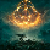

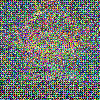

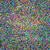

In [68]:
# Test
image_path = "img1.png"
original_array = load_image(image_path)

upscaled_array = upscale_image(original_array, 2)
downscaled_array = downscale_to_original_size(upscaled_array, original_array.shape)

original = Image.fromarray(original_array)
up = Image.fromarray(upscaled_array)
down = Image.fromarray(downscaled_array)
display(original)
display(up)
display(down)

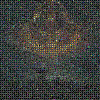

Final best cost: 1709.3136


In [69]:
image_path = "img1.png"
original_array = load_image(image_path)

# Create problem and parameters
params = parameters()
prob = problem(original_array, params.upscale_factor)

# Run genetic algorithm
pop, best, best_cost = run_genetic(prob, params)
print("Final best cost:", best_cost)

